In [480]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import RobustScaler
from scipy.interpolate import UnivariateSpline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from statsmodels.api import OLS
from scipy.stats import norm
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [481]:
def load_data(train_path, test_path):
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    return train_data, test_data

In [482]:
def visualize_data(data, features):
    for feature in features:
        plt.figure(figsize=(10, 4))

        # Boxplot for outlier detection
        plt.subplot(1, 2, 1)
        sns.boxplot(data[feature])
        plt.title(f'Boxplot of {feature}')

        # Histogram for distribution
        plt.subplot(1, 2, 2)
        sns.histplot(data[feature], kde=True)
        plt.title(f'Distribution of {feature}')

        plt.show()

In [483]:
def plot_residuals(residuals, y_pred):
    plt.scatter(y_pred, residuals)
    plt.title('Residuals vs. Predicted Values')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()

In [484]:
def normality(residuals):
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Normal Q-Q plot')
    plt.show()

In [485]:
def preprocess_data(data, features, imputer):
    data[features] = imputer.transform(data[features])
    return data

In [486]:
def train_model_statsmodels(X, y):
    X = sm.add_constant(X)  # Adding a constant to the model
    model = sm.OLS(y, X).fit(cov_type='HC0')
    return model

In [487]:
def generate_polynomials(data):
    poly = PolynomialFeatures(degree=2, include_bias=True)
    data = poly.fit_transform(data)

    feature_names = poly.get_feature_names_out()
    data = pd.DataFrame(data, columns=feature_names)
    return data

In [488]:
def select_features(X, y, top=100):
    lasso = Lasso(alpha =0.05, random_state=1)
    lasso.fit(X, y)
    
    weights = lasso.coef_
    top = min(len(weights), top)
    
    threshold = np.sort(np.abs(weights))[-top]
    
    # Identify columns with weight below 0.5
    columns_to_delete = [column for column, weight in zip(list(lasso.feature_names_in_), weights) if abs(weight) <= threshold]

    # Delete these columns from X
    X = X.drop(columns=columns_to_delete)
    return X.columns

In [489]:
ordinal_mapping = {
    'Ex': 4,  # Excellent
    'Gd': 3,  # Good
    'TA': 2,  # Average/Typical
    'Fa': 1,  # Fair
    'Po': 0   # Poor
}

def data_mapping(train_data, test_data, column, mapping=ordinal_mapping):
    train_data[column] = train_data[column].map(mapping)
    test_data[column] = test_data[column].map(mapping)
    return train_data[column], test_data[column]

In [490]:
# Paths to the datasets
train_path = 'train.csv'
test_path = 'test.csv'

# Load the data
train_data, test_data = load_data(train_path, test_path)

original_train = pd.read_csv(train_path)

data_mapping(train_data, test_data, 'KitchenQual')
             
#convert categorical variable into dummy
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)

# Visualize data
selected_features = ['KitchenQual', 'SaleCondition_Normal', 'ExterQual_TA', 'LotArea','YrSold', 'OverallQual', 'OverallCond', 'GrLivArea', 'TotalBsmtSF','GarageCars', 'MSSubClass', 'YearBuilt']
#visualize_data(train_data, selected_features)

In [491]:
# Handling missing values
imputer = SimpleImputer(strategy='constant', fill_value=0)
train_data[selected_features] = imputer.fit_transform(train_data[selected_features])

# Preprocessing the test data
test_data = preprocess_data(test_data, selected_features, imputer)

# Apply log transformation to the target variable 'SalePrice'
train_data['SalePrice'] = np.log1p(train_data['SalePrice'])
y = train_data['SalePrice']

# Splitting the train data into X (features) and y (target)
X = train_data[selected_features]

X_poly = generate_polynomials(X)
X_test = generate_polynomials(test_data[selected_features])
'''
X_poly = generate_polynomials(X_poly)
X_test = generate_polynomials(X_test)

selected_features_lasso = select_features(X_poly, y, top=100)

X_poly = X_poly[selected_features_lasso]
X_test = X_test[selected_features_lasso]
'''

'\nX_poly = generate_polynomials(X_poly)\nX_test = generate_polynomials(X_test)\n\nselected_features_lasso = select_features(X_poly, y, top=100)\n\nX_poly = X_poly[selected_features_lasso]\nX_test = X_test[selected_features_lasso]\n'

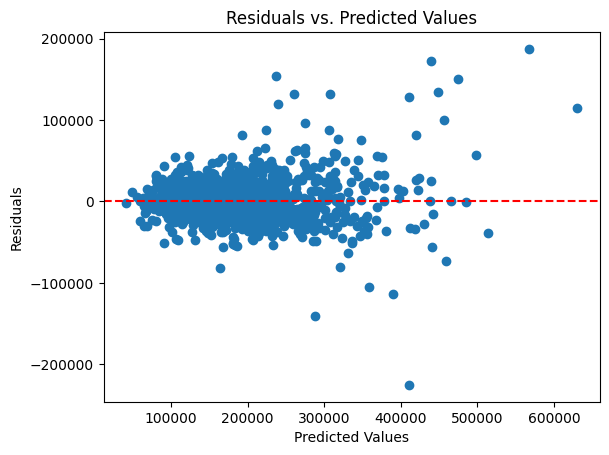

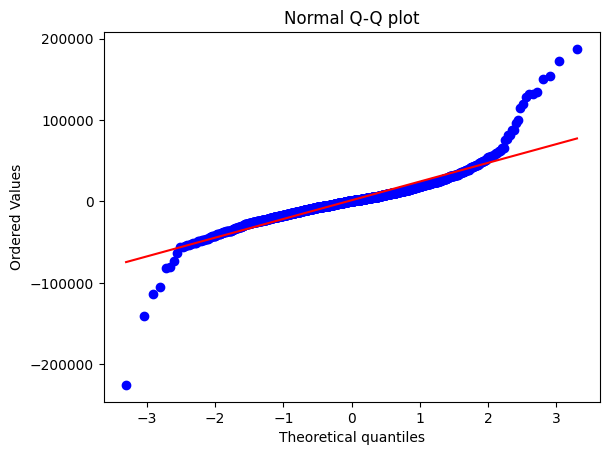

R-squared value: 0.9022952548614114


In [492]:
# Training the models
model = train_model_statsmodels(X_poly, y)

# Evaluating the model
X_poly = sm.add_constant(X_poly)  # Adding a constant to the validation data
y_pred_log =model.predict(X_poly)  # Predicted log-transformed prices
y_pred = np.expm1(y_pred_log)  # Inverse transformation
r_squared = r2_score(np.expm1(y), y_pred)
residuals = np.expm1(y) - y_pred
plot_residuals(residuals, y_pred)
normality(residuals)
print("R-squared value:", r_squared)

In [493]:
'''
weights = lasso.coef_
plt.hist(weights, bins=50, log=True)

# Identify columns with weight below 0.5
columns_to_delete = [column for column, weight in zip(list(lasso.feature_names_in_), weights) if abs(weight) <= 3e-10]

# Delete these columns from X
X_filtered = X_poly.drop(columns=columns_to_delete)
X_filtered_test = X_test.drop(columns=columns_to_delete)
X_filtered_test
'''

'\nweights = lasso.coef_\nplt.hist(weights, bins=50, log=True)\n\n# Identify columns with weight below 0.5\ncolumns_to_delete = [column for column, weight in zip(list(lasso.feature_names_in_), weights) if abs(weight) <= 3e-10]\n\n# Delete these columns from X\nX_filtered = X_poly.drop(columns=columns_to_delete)\nX_filtered_test = X_test.drop(columns=columns_to_delete)\nX_filtered_test\n'

In [494]:
'''
model = train_model_statsmodels(X_filtered, y_train)

# Evaluating the model
X_filtered = sm.add_constant(X_filtered)  # Adding a constant to the validation data
y_pred_log =model.predict(X_filtered)  # Predicted log-transformed prices
y_pred = np.expm1(y_pred_log)  # Inverse transformation
r_squared = r2_score(np.expm1(y), y_pred)
residuals = np.expm1(y) - y_pred
plot_residuals(residuals, y_pred)
normality(residuals)
print("R-squared value:", r_squared)
'''

'\nmodel = train_model_statsmodels(X_filtered, y_train)\n\n# Evaluating the model\nX_filtered = sm.add_constant(X_filtered)  # Adding a constant to the validation data\ny_pred_log =model.predict(X_filtered)  # Predicted log-transformed prices\ny_pred = np.expm1(y_pred_log)  # Inverse transformation\nr_squared = r2_score(np.expm1(y), y_pred)\nresiduals = np.expm1(y) - y_pred\nplot_residuals(residuals, y_pred)\nnormality(residuals)\nprint("R-squared value:", r_squared)\n'

In [495]:
# Predicting the housing prices for the test data
X_test = sm.add_constant(X_test)  # Adding a constant to the test data
predicted_log_prices = model.predict(X_test)  # Predicted log-transformed prices for test data
predicted_prices = np.expm1(predicted_log_prices)  # Inverse transformation for test data predictions

In [496]:
''
# Saving the predictions
predicted_prices_df = pd.DataFrame({
    'Id': test_data['Id'],
    'SalePrice': predicted_prices
})
predicted_prices_df.to_csv('predicted_housing_prices_statsmodels.csv', index=False)
''

''

In [497]:
train_data.columns.tolist()

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice',
 'MSZoning_C (all)',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Street_Grvl',
 'Street_Pave',
 'Alley_Grvl',
 'Alley_Pave',
 'LotShape_IR1',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'LandContour_Bnk',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'Utilities_AllPub',
 'Utilities_NoSeWa',
 'LotConfig_Corner',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LotConfig

In [498]:
error = np.expm1(y) - y_pred
error = np.abs(error)
error_ascending = error.sort_values()
train_data['error'] = error
train_data.sort_values(by='error')

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,error
298,299,60,90.0,11700,6,6,1968,1968,365.0,384,...,False,False,True,False,False,False,False,1,False,1.107148
1151,1152,20,134.0,17755,5,4,1959,1959,132.0,176,...,False,False,True,False,False,False,False,1,False,2.367251
1257,1258,30,56.0,4060,5,8,1922,1950,0.0,0,...,False,False,True,False,False,False,False,1,False,26.755773
604,605,20,88.0,12803,7,5,2002,2002,99.0,922,...,False,False,True,False,False,False,False,1,False,41.706396
1039,1040,180,21.0,1477,4,4,1970,1970,0.0,509,...,False,False,True,False,False,False,False,1,False,49.899402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169,1170,60,118.0,35760,10,5,1995,1996,1378.0,1387,...,False,False,True,False,False,False,False,1,False,150242.168208
688,689,20,60.0,8089,8,6,2007,2007,0.0,945,...,True,False,False,False,False,False,False,0,True,154619.563650
898,899,20,100.0,12919,9,5,2009,2010,760.0,2188,...,True,False,False,False,False,False,False,0,True,172153.645947
691,692,60,104.0,21535,10,6,1994,1995,1170.0,1455,...,False,False,True,False,False,False,False,1,False,187443.259507


In [499]:
train_merged = pd.merge(original_train, train_data[['Id', 'error']], on='Id')
train_merged

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,error
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,7679.021544
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,1828.276297
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,11693.651099
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,18334.290590
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,36216.157878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,8,2007,WD,Normal,175000,6187.467610
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000,1021.689994
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500,22150.866149
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,4,2010,WD,Normal,142125,12583.422578


In [500]:
train_merged.sort_values(by='error')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,error
298,299,60,RL,90.0,11700,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,6,2007,WD,Normal,175000,1.107148
1151,1152,20,RL,134.0,17755,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,11,2006,WD,Normal,149900,2.367251
1257,1258,30,RL,56.0,4060,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,7,2009,WD,Normal,99900,26.755773
604,605,20,RL,88.0,12803,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,221000,41.706396
1039,1040,180,RM,21.0,1477,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,4,2009,WD,Normal,80000,49.899402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169,1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,7,2006,WD,Normal,625000,150242.168208
688,689,20,RL,60.0,8089,Pave,NaN,Reg,HLS,AllPub,...,NaN,NaN,NaN,0,10,2007,New,Partial,392000,154619.563650
898,899,20,RL,100.0,12919,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,3,2010,New,Partial,611657,172153.645947
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,1,2007,WD,Normal,755000,187443.259507


In [501]:
correlations = pd.get_dummies(train_merged).astype(np.float64).corrwith(train_merged['error'])
correlations

Id                      -0.015872
MSSubClass               0.003057
LotFrontage              0.196926
LotArea                  0.152748
OverallQual              0.347116
                           ...   
SaleCondition_AdjLand   -0.010215
SaleCondition_Alloca     0.074455
SaleCondition_Family     0.028608
SaleCondition_Normal    -0.231234
SaleCondition_Partial    0.252568
Length: 290, dtype: float64

In [502]:
correlations.sort_values().tail(50)

PoolArea                 0.090438
LandSlope_Mod            0.098081
LotShape_IR1             0.100730
Exterior1st_CemntBd      0.101839
GarageType_BuiltIn       0.102491
PoolQC_Ex                0.106586
WoodDeckSF               0.126708
RoofMatl_WdShngl         0.130459
BsmtUnfSF                0.132508
YearBuilt                0.134842
LandContour_HLS          0.142739
GarageYrBlt              0.143593
Neighborhood_NridgHt     0.144314
Neighborhood_Crawfor     0.144611
Neighborhood_StoneBr     0.150345
RoofStyle_Hip            0.150513
LotArea                  0.152748
FireplaceQu_Ex           0.153175
OpenPorchSF              0.158887
Neighborhood_NoRidge     0.161344
MasVnrType_Stone         0.161622
BsmtFinType1_GLQ         0.163067
GarageFinish_Fin         0.163111
HeatingQC_Ex             0.163163
YearRemodAdd             0.171117
ExterQual_Gd             0.171345
2ndFlrSF                 0.172827
FireplaceQu_Gd           0.176232
Foundation_PConc         0.187395
LotFrontage   